In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
image = cv2.imread("baboon.png")

In [3]:
im_gray = cv2.imread('barbara.png', cv2.IMREAD_GRAYSCALE)

In [4]:
im_gray

array([[181, 201, 202, ..., 103, 102,  92],
       [171, 198, 201, ...,  94,  96,  96],
       [175, 195, 193, ...,  87,  96,  98],
       ...,
       [100,  97,  97, ..., 114, 113, 117],
       [ 94,  97,  99, ..., 111, 112, 114],
       [ 96,  95,  98, ..., 113, 104, 109]], dtype=uint8)

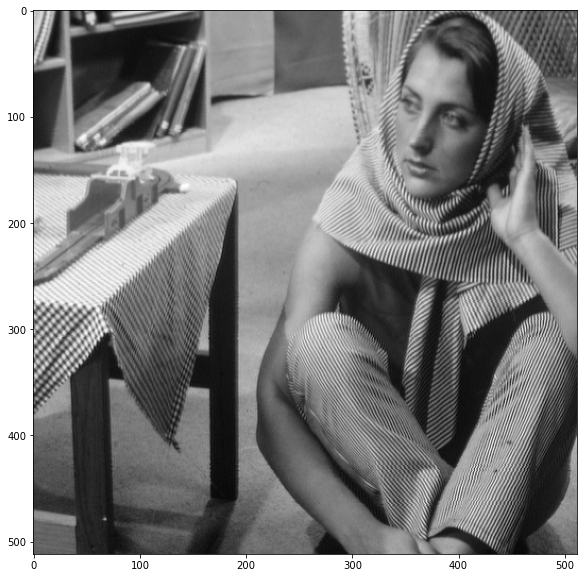

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(im_gray,cmap='gray')
plt.show()

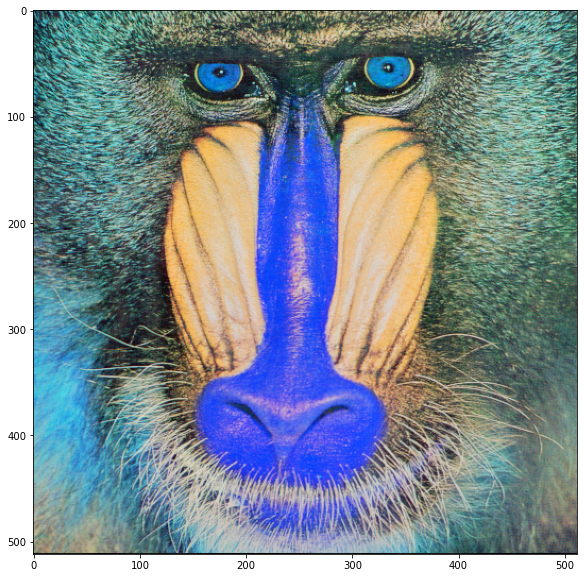

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()

In [7]:
hr = cv2.calcHist([image],[0],None,[256],[0,256])

In [8]:
x = [x for x in range(256)]

<BarContainer object of 256 artists>

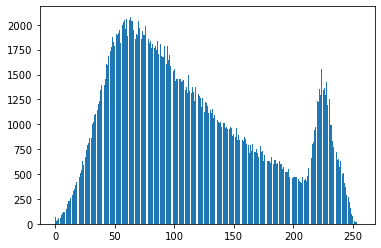

In [9]:
plt.bar(x,hr[:,0])

In [10]:
PMF = hr / (im_gray.shape[0] * im_gray.shape[1])

<BarContainer object of 256 artists>

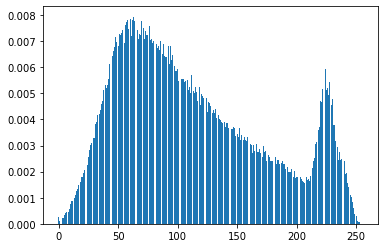

In [11]:
plt.bar(x, PMF[:,0])

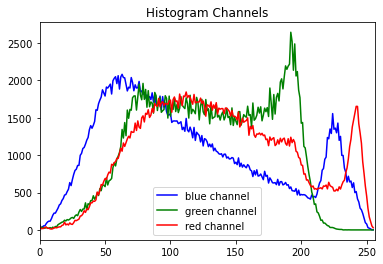

In [12]:
color = ('blue','green','red')
for i,col in enumerate(color):
    histr = cv2.calcHist([image],[i],None,[256],[0,256])
    plt.plot(x,histr,color = col,label=col+" channel")
    
    plt.xlim([0,256])
plt.legend()
plt.title("Histogram Channels")
plt.show()

In [13]:
hr_baboob_gr = cv2.calcHist([image],[1],None,[256],[0,256])

<BarContainer object of 256 artists>

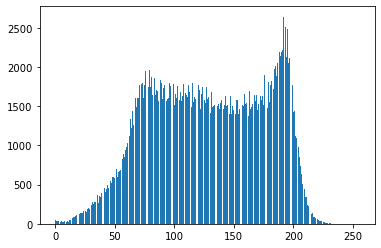

In [14]:
plt.bar(x,hr_baboob_gr[:,0])

In [15]:
m = [6,10,16,20]

def moving_avg_hist(hr , m):
    
    arr_moving = [0 for i in range(256-m)]
    for i in range(m//2 , 255-m//2):
        arr_moving[i-m//2] = sum(hr[i-m//2:i+m//2])/m
    return(arr_moving)

In [16]:
def moving_avg(hr , m):
    
    arr_moving = [0 for i in range(256-m)]
    for i in range(m//2 , 255-m//2):
        arr_moving[i-m//2] = sum(hr[i-m//2:i+m//2])/m
    return(arr_moving)

def moving_avg_hist(hr , m , disp_img = True, disp_arr = False):
    '''
    input
    hr= hist value of image
    m = window value 
    disp_image = True if we want to display plot 
    disp_arr = True if we want to see transformed hr values
    
    output
    barplot and transformed hist values
    
    '''
    if type(m) == int:
        arr = moving_avg(hr , m)
        x = [j for j in range(len(arr))]
        if disp_img and disp_arr:    
            plt.bar(x , arr)
            plt.title("moving_avg_hist for m = "+ str(m))
            return(arr)
        elif disp_img and not disp_arr:
            plt.bar(x , arr)
            plt.title("moving_avg_hist for m = "+ str(m))
        elif not disp_img and disp_arr:
            return(arr)
    
    if type(m) ==list:
        mat = []
        
        for i in m:
            arr = arr = moving_avg(hr , i)
            x = [j for j in range(256-i)]
            mat.append(arr)
        if disp_img and disp_arr:
            
            for i in range(len(m)):
                plt.bar(x , arr)
                plt.title("moving_avg_hist for m = "+ str(m[i]))
            return(mat)
        
        elif disp_img and not disp_arr:
            for i in range(len(m)):
                plt.subplots()
                plt.bar(x , arr )
                plt.title("moving_avg_hist for m = "+ str(m[i]))
                plt.show()
        elif not disp_img and disp_arr:
            return(mat)
  

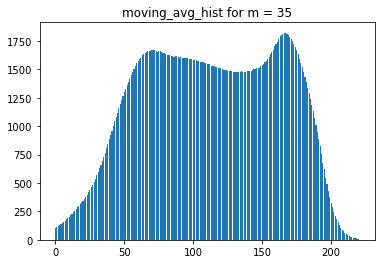

In [17]:
moving_avg_hist(hr_baboob_gr[:,0] , 35 , disp_img = True, disp_arr = False )

In [18]:
def sobel(img_gray):
    
    ddepth = cv2.CV_16S
    # Applys the filter on the image in the X direction
    grad_x = cv2.Sobel(src=img_gray, ddepth=ddepth, dx=1, dy=0, ksize=3)
    # Applys the filter on the image in the Y direction
    grad_y = cv2.Sobel(src=img_gray, ddepth=ddepth, dx=0, dy=1, ksize=3)
    # Converts the values back to a number between 0 and 255
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    # Adds the derivative in the X and Y direction
    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    
    return(grad)

In [19]:
sobel_ = sobel(im_gray)

In [20]:
def S_val_mat(grad , th):
    for i in range(grad.shape[0]):
        for j in range(grad.shape[1]):
            if grad[i,j]>th:
                grad[i,j] = 1
            else:
                grad[i,j] = 0
    return(grad)

def s_val(grad , idx , idy):
    return(sum(grad[idx-1:idx+1 , idy-1]) + sum(grad[idx-1:idx+1 , idy])+ sum(grad[idx-1:idx+1 , idy+1]))

In [21]:
def H_val(image):
    
    hr = cv2.calcHist([image],[0],None,[256],[0,256])
    hr = [x for x in hr[:,0] if x>0]
    pr_hr = hr/sum(hr)
    pr_log = np.log2(pr_hr)
    h = pr_hr*pr_log
    
    H = -sum(h)
    return(H)

In [22]:
H_val(im_gray)

7.6321189909940585

In [23]:
grad = sobel(im_gray)
grad = S_val_mat(grad)
grad

TypeError: S_val_mat() missing 1 required positional argument: 'th'

In [24]:
def Otsu_algo(image , is_normalized = False):

    bins_num = len(hr)
    
    arr = [x for x in hr]

    hist, bin_edges = np.histogram(image, bins=bins_num)

    if is_normalized:
        hist = np.divide(hist.ravel(), hist.max())

    bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2
    weight1 = np.cumsum(hist)
    weight2 = np.cumsum(hist[::-1])[::-1]
    mean1 = np.cumsum(hist * bin_mids) / weight1
    mean2 = (np.cumsum((hist * bin_mids)[::-1]) / weight2[::-1])[::-1]
    inter_class_variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:])**2
    index_of_max_val = np.argmax(inter_class_variance)

    threshold = bin_mids[:-1][index_of_max_val]
    
    return(threshold)

In [25]:
def bht(hist, min_count= 1):
    """Balanced histogram thresholding."""
    n_bins = len(hist)  # assumes 1D histogram
    h_s = 0
    while hist[h_s] < min_count:
        h_s += 1  # ignore small counts at start
    h_e = n_bins - 1
    while hist[h_e] < min_count:
        h_e -= 1  # ignore small counts at end
    # use mean intensity of histogram as center; alternatively: (h_s + h_e) / 2)
    h_c = int(round(np.average(np.linspace(0, 2 ** 8 - 1, n_bins), weights=hist)))
    w_l = np.sum(hist[h_s:h_c])  # weight in the left part
    w_r = np.sum(hist[h_c : h_e + 1])  # weight in the right part

    while h_s < h_e:
        if w_l > w_r:  # left part became heavier
            w_l -= hist[h_s]
            h_s += 1
        else:  # right part became heavier
            w_r -= hist[h_e]
            h_e -= 1
        new_c = int(round((h_e + h_s) / 2))  # re-center the weighing scale

        if new_c < h_c:  # move bin to the other side
            w_l -= hist[h_c]
            w_r += hist[h_c]
        elif new_c > h_c:
            w_l += hist[h_c]
            w_r -= hist[h_c]

        h_c = new_c

    return h_c

In [26]:
def _Otsu_image(image):
    
    hr = cv2.calcHist([image],[0],None,[256],[0,256])
    density_hr = np.array(hr[:,0])/(image.shape[0]*image.shape[1])
    var = []
    bins = [x for x in range(1,len(density_hr)+1)]
    for i in range(1, len(density_hr)-1):
        g_1 = np.cumsum(density_hr[:i])
        g_2 = np.cumsum(density_hr[i:])

        mean_g_1 = np.sum(bins[:i]*density_hr[:i])/g_1[-1]
        mean_g_2 = np.sum(bins[i:]*density_hr[i:])/g_2[-1]

        mean_global = np.sum(bins*density_hr)

        var_val = g_1[-1]*(mean_g_1 - mean_global)**2 + g_2[-1]*(mean_g_2 - mean_global)**2

        var.append(var_val)
    var = np.array(var)
    
    var = np.nan_to_num(var, copy=True, nan=0.0, posinf=None, neginf=None)

    return(np.argmax(var))
   

In [27]:
def _Otsu_hist(hr, image):
    density_hr = np.array(hr)/(image.shape[0]*image.shape[1])
    var = []
    bins = [x for x in range(1,len(density_hr)+1)]
    for i in range(1, len(density_hr)-1):
        g_1 = np.cumsum(density_hr[:i])
        g_2 = np.cumsum(density_hr[i:])

        mean_g_1 = np.sum(bins[:i]*density_hr[:i])/g_1[-1]
        mean_g_2 = np.sum(bins[i:]*density_hr[i:])/g_2[-1]

        mean_global = np.sum(bins*density_hr)

        var_val = g_1[-1]*(mean_g_1 - mean_global)**2 + g_2[-1]*(mean_g_2 - mean_global)**2

        var.append(var_val)
    var = np.array(var)

    var = np.nan_to_num(var, copy=True, nan=0.0, posinf=None, neginf=None)

    return(np.argmax(var))

In [28]:
def biLevelThresholding(image , m , th):
    
    H = H_val(image)
    hr = cv2.calcHist([image],[0],None,[256],[0,256])
    hr_mv = moving_avg_hist(hr[:,0] , m , disp_img = False, disp_arr = True )
    grad = sobel(image)
    grad = S_val_mat(grad, th)
    
    
    thresh = _Otsu_hist(hr_mv, image) +m/2
    
    
    bi_img = np.zeros((image.shape[0] , image.shape[1]))
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i,j] > thresh:
                bi_img[i,j] =255
                
            elif H>4.5 and image[i,j]<= 3*thresh/4:
                bi_img[i,j] =0
            elif H<= 4.5 and image[i,j]<= thresh/2:
                bi_img[i,j] =0
            elif i!=0 and j!=0 and i!=image.shape[0]-1 and j!=image.shape[1]-1 and s_val(grad , i , j) ==9:
                bi_img[i,j] =0
            elif i!=0 and j!=0 and i!=image.shape[0]-1 and j!=image.shape[1]-1 and s_val(grad , i , j) !=9:
                bi_img[i,j] =255
    return(bi_img, thresh)

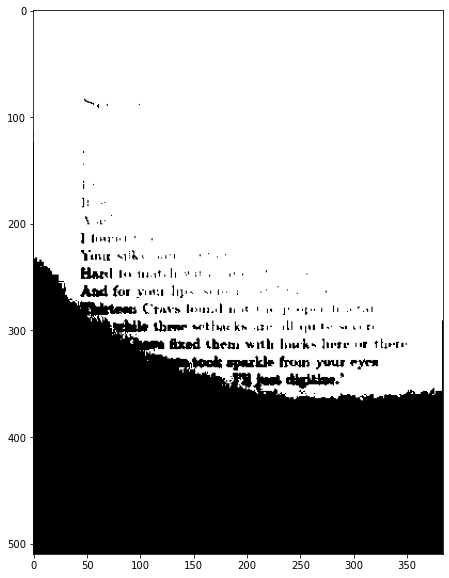

In [29]:
dImg_2 = cv2.imread("son2.jpg", cv2.IMREAD_GRAYSCALE)
bi_img , th = biLevelThresholding(dImg_2 , 80 , 45)
plt.figure(figsize=(10,10))
plt.imshow(bi_img, cmap = "gray")

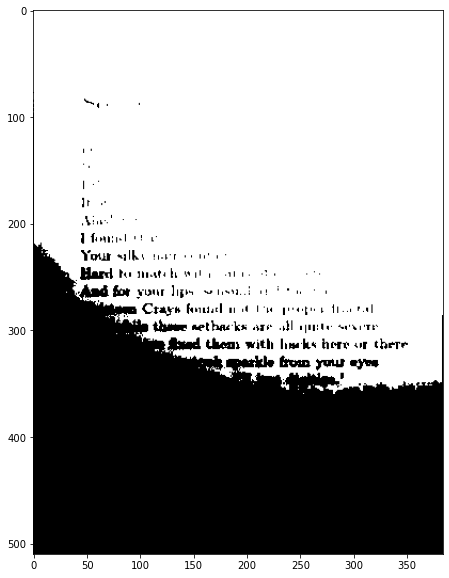

In [30]:
dImg_2 = cv2.imread("son2.jpg", cv2.IMREAD_GRAYSCALE)
bi_img , th = biLevelThresholding(dImg_2 , 30 , 45)
plt.figure(figsize=(10,10))
plt.imshow(bi_img, cmap = "gray")

<ipython-input-27-14c8345e5f65>:9: RuntimeWarning: invalid value encountered in double_scalars
  mean_g_1 = np.sum(bins[:i]*density_hr[:i])/g_1[-1]


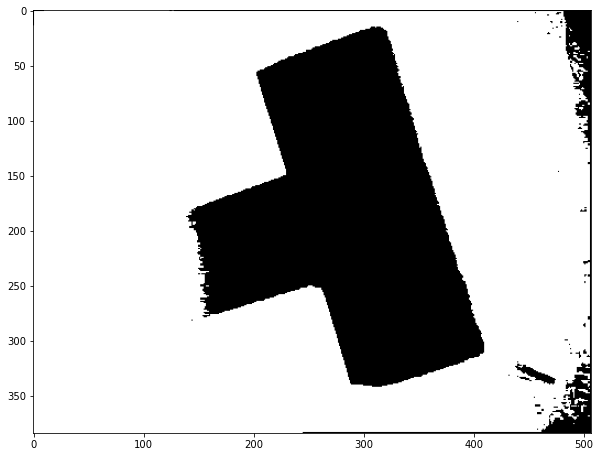

In [31]:
dImg_3 = cv2.imread("wdg.jpg", cv2.IMREAD_GRAYSCALE)
bi_img , th = biLevelThresholding(dImg_3 , 50 , 45)
plt.figure(figsize=(10,10))
plt.imshow(bi_img, cmap = "gray")

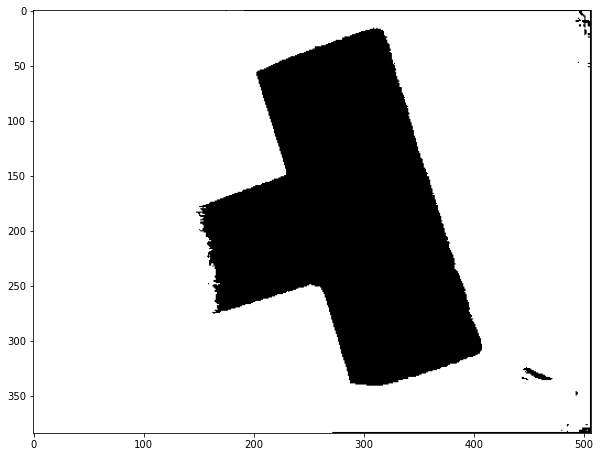

In [32]:
dImg_3 = cv2.imread("wdg.jpg", cv2.IMREAD_GRAYSCALE)
bi_img , th = biLevelThresholding(dImg_3 , 60 , 25)
plt.figure(figsize=(10,10))
plt.imshow(bi_img, cmap = "gray")

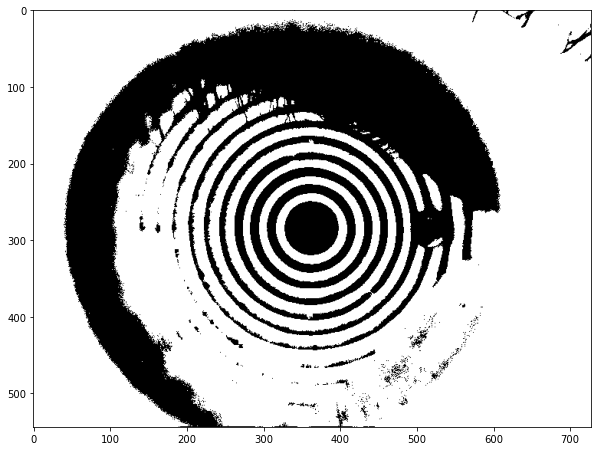

In [33]:
dImg_4 = cv2.imread("dummy_img_1.png", cv2.IMREAD_GRAYSCALE)
bi_img , th = biLevelThresholding(dImg_4 , 50 , 50)
plt.figure(figsize=(10,10))
plt.imshow(bi_img, cmap = "gray")

In [35]:
plt.figure(figsize=(10,10))
plt.imshow(arr, cmap = "gray")

NameError: name 'arr' is not defined

<Figure size 720x720 with 0 Axes>

In [ ]:
def _Otsu(hr, image):
    density_hr = np.array(hr[:,0])/(image.shape[0]*image.shape[1])
    var = []
    bins = [x for x in range(1,len(density_hr)+1)]
    for i in range(1, len(density_hr)-1):
        g_1 = np.cumsum(density_hr[:i])
        g_2 = np.cumsum(density_hr[i:])

        mean_g_1 = np.sum(bins[:i]*density_hr[:i])/g_1[-1]
        mean_g_2 = np.sum(bins[i:]*density_hr[i:])/g_2[-1]

        mean_global = np.sum(bins*density_hr)

        var_val = g_1[-1]*(mean_g_1 - mean_global)**2 + g_2[-1]*(mean_g_2 - mean_global)**2

        var.append(var_val)
    var = np.array(var)
    
    var = np.nan_to_num(var, copy=True, nan=0.0, posinf=None, neginf=None)

    return(np.argmax(var))
   

In [ ]:
hist = cv2.calcHist([dImg_3],[0],None,[256],[0,256])

hist_mv = moving_avg_hist(hist , 30 , disp_img = False, disp_arr = True)



In [ ]:
thresh = _Otsu_hist(hist_mv, dImg_3)

thresh

### Verifying result of Otsu using CV's default function 

In [ ]:
ret2,th2 = cv2.threshold(dImg_3,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret2,th2

### Result matched

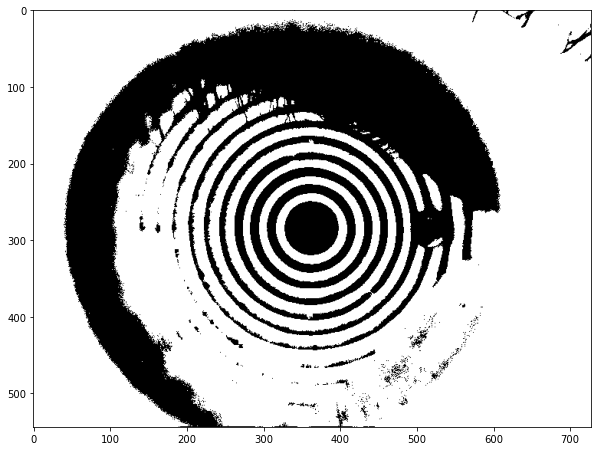

In [36]:
dImg_4 = cv2.imread("dummy_img_1.png", cv2.IMREAD_GRAYSCALE)
bi_img , th = biLevelThresholding(dImg_4 , 50 , 25)
plt.figure(figsize=(10,10))
plt.imshow(bi_img, cmap = "gray")

In [37]:
dImg_4

array([[212, 226, 214, ..., 160, 162, 161],
       [211, 208, 207, ..., 173, 170, 172],
       [202, 208, 223, ..., 177, 170, 168],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

<BarContainer object of 256 artists>

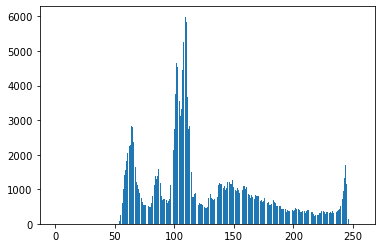

In [38]:

hr = cv2.calcHist([dImg_3],[0],None,[256],[0,256])
plt.bar(x,hr[:,0])

C:\Users\AMAN-PC\anaconda3\lib\site-packages\numpy\lib\stride_tricks.py:537: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
C:\Users\AMAN-PC\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


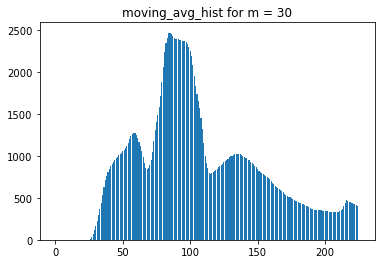

In [39]:
hist = cv2.calcHist([dImg_3],[0],None,[256],[0,256])

hist_mv = moving_avg_hist(hist , 30 , disp_img = True, disp_arr = False)

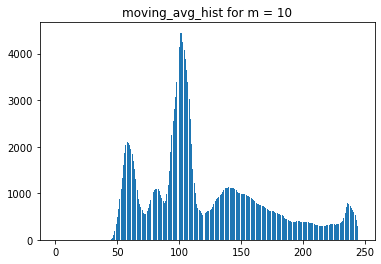

In [40]:
hist_mv = moving_avg_hist(hist , 10 , disp_img = True, disp_arr = True)

In [41]:
thresh = _Otsu_hist(hist_mv, dImg_3)

thresh

<ipython-input-27-14c8345e5f65>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  density_hr = np.array(hr)/(image.shape[0]*image.shape[1])
<ipython-input-27-14c8345e5f65>:9: RuntimeWarning: invalid value encountered in true_divide
  mean_g_1 = np.sum(bins[:i]*density_hr[:i])/g_1[-1]


135

In [42]:
len(hist_mv)

246

In [43]:
def sobel(img_gray):
    
    ddepth = cv2.CV_16S
    # Applys the filter on the image in the X direction
    grad_x = cv2.Sobel(src=img_gray, ddepth=ddepth, dx=1, dy=0, ksize=3)
    # Applys the filter on the image in the Y direction
    grad_y = cv2.Sobel(src=img_gray, ddepth=ddepth, dx=0, dy=1, ksize=3)
    # Converts the values back to a number between 0 and 255
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    # Adds the derivative in the X and Y direction
    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    
    return(grad)

In [44]:
def S_val_mat(grad , th):
    for i in range(grad.shape[0]):
        for j in range(grad.shape[1]):
            if grad[i,j]>th:
                grad[i,j] = 1
            else:
                grad[i,j] = 0
    return(grad)

In [45]:

sobel_img = sobel(dImg_3)

sobel_img_S = S_val_mat(sobel_img , 25)

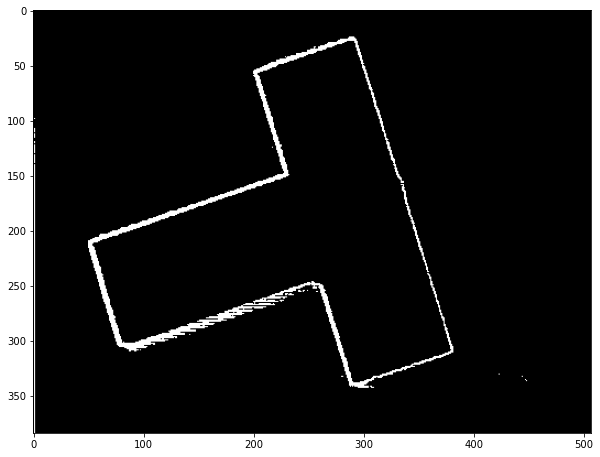

In [46]:
plt.figure(figsize=(10,10))
plt.imshow(sobel_img, cmap = "gray")

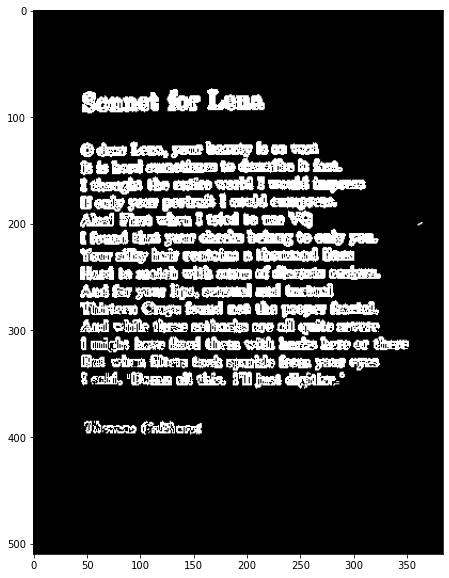

In [47]:
sobel_img = sobel(dImg_2)

sobel_img_S = S_val_mat(sobel_img , 22)
plt.figure(figsize=(10,10))
plt.imshow(sobel_img_S, cmap = "gray")

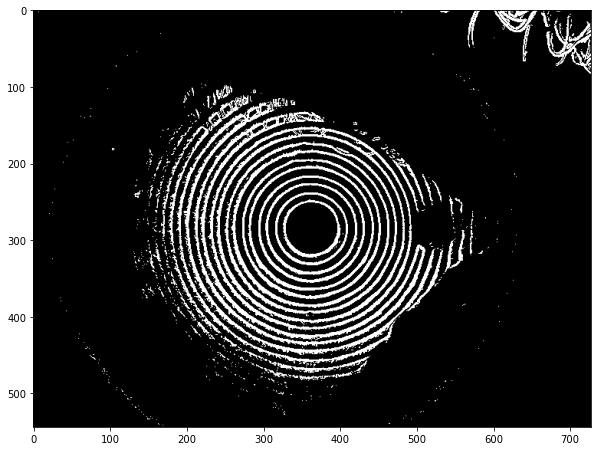

In [48]:
sobel_img = sobel(dImg_4)

sobel_img_S = S_val_mat(sobel_img , 75)
plt.figure(figsize=(10,10))
plt.imshow(sobel_img_S, cmap = "gray")

In [49]:
H_val(dImg_3)

7.102672979788622

In [50]:
H_val(dImg_2)

7.708617709053215

In [51]:
sobel_img = sobel(im_gray)

sobel_img_S = S_val_mat(sobel_img , 125)
plt.figure(figsize=(10,10))
plt.imshow(arr, cmap = "gray")

NameError: name 'arr' is not defined

<Figure size 720x720 with 0 Axes>

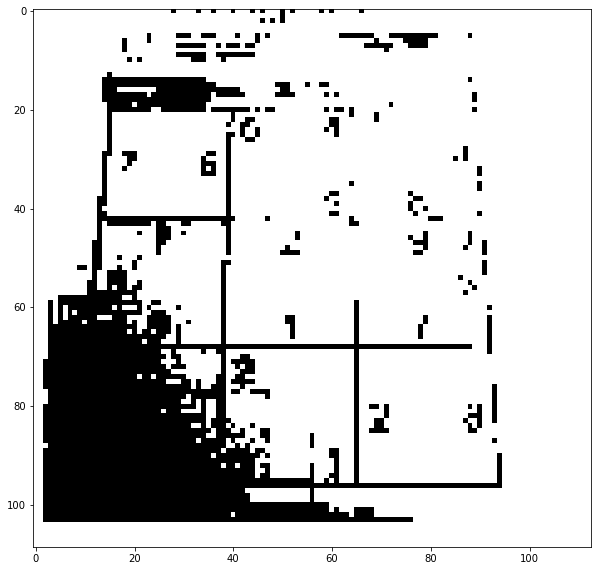

In [53]:
dImg_4 = cv2.imread("dummy_img_4.png", cv2.IMREAD_GRAYSCALE)
bi_img , th = biLevelThresholding(dImg_4 , 30
                                  , 45)
plt.figure(figsize=(10,10))
plt.imshow(bi_img, cmap = "gray")

<ipython-input-27-14c8345e5f65>:10: RuntimeWarning: invalid value encountered in double_scalars
  mean_g_2 = np.sum(bins[i:]*density_hr[i:])/g_2[-1]


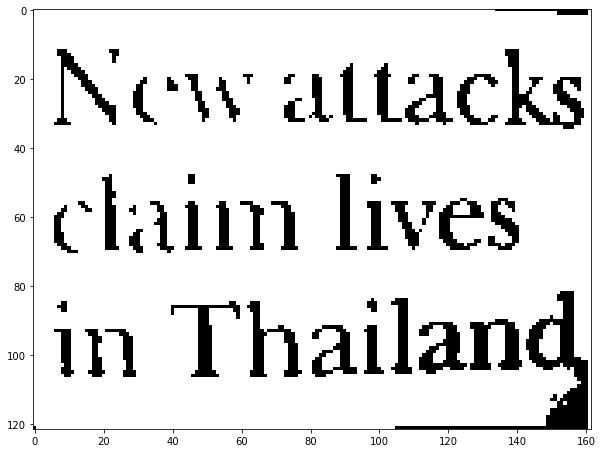

In [61]:
dImg_5 = cv2.imread("dummy_img_5.png", cv2.IMREAD_GRAYSCALE)
bi_img , th = biLevelThresholding(dImg_5 , 25, 60)
plt.figure(figsize=(10,10))
plt.imshow(bi_img, cmap = "gray")

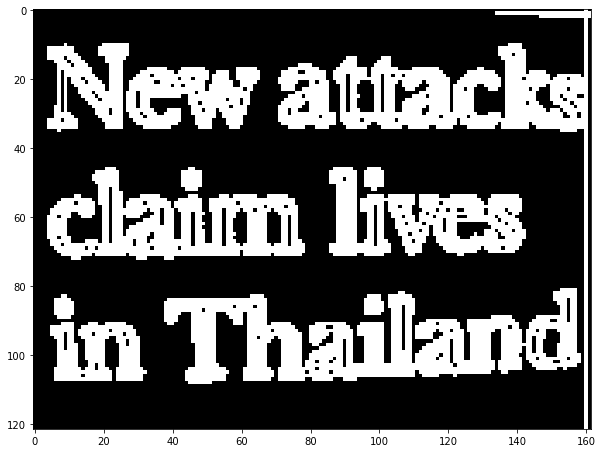

In [67]:
sobel_img = sobel(dImg_5)

sobel_img_S = S_val_mat(sobel_img , 45)
plt.figure(figsize=(10,10))
plt.imshow(sobel_img_S, cmap = "gray")

In [69]:
a = [[1,2,3] , [2,3,4]]

set(a[1])

{2, 3, 4}

In [70]:
ll =  []
ll.append(a[0])
ll.append(a[1])
ll

[[1, 2, 3], [2, 3, 4]]